## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
# assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
print(len(text))
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

2205
OK!


### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2025-12-14 23:54:12--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2025-12-14 23:54:13 (8.53 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
print(len(text))
text = "".join(text).lower()

print('OK!')


7088
OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
#tokens = sorted(set(out))
tokens = sorted(list(set(text)))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here
idx_to_token = {i: token for i, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
token_to_idx = {token: i for i, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_tokens = num_tokens
        self.rnn_num_units = rnn_num_units
        self.emb_size = emb_size

        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev=None):

        x_emb = self.emb(x)
        output, h_next = self.rnn(x_emb, h_prev)
        logits = self.hid_to_logits(output)

        return logits, h_next

    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.rnn_num_units)


num_tokens = len(tokens)
emb_size = 32
rnn_num_units = 128

model = CharRNNLoop(num_tokens=num_tokens, emb_size=emb_size, rnn_num_units=rnn_num_units)
opt = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

def get_batch(text, batch_size=32, seq_length=64):
    batch_ix = np.random.randint(0, len(text) - seq_length, batch_size)

    batch_str = [text[i:i+seq_length+1] for i in batch_ix]

    batch_matrix = [[token_to_idx[c] for c in s] for s in batch_str]
    batch_tensor = torch.tensor(batch_matrix, dtype=torch.int64)

    x = batch_tensor[:, :-1]
    y = batch_tensor[:, 1:]
    return x, y

history = []
MAX_LENGTH = 16

for i in range(1000):
    batch_x, batch_y = get_batch(text)

    logits, _ = model(batch_x)
    loss = criterion(logits.reshape(-1, num_tokens), batch_y.reshape(-1))

    opt.zero_grad()
    loss.backward()
    opt.step()

    history.append(loss.item())

    if (i+1) % 100 == 0:
        print(f"Шаг {i+1}, Loss {loss.item()}")

Шаг 100, Loss 2.86541748046875
Шаг 200, Loss 2.5313920974731445
Шаг 300, Loss 2.433210611343384
Шаг 400, Loss 2.3746328353881836
Шаг 500, Loss 2.319680690765381
Шаг 600, Loss 2.2479023933410645
Шаг 700, Loss 2.2203986644744873
Шаг 800, Loss 2.177191734313965
Шаг 900, Loss 2.190526008605957
Шаг 1000, Loss 2.1643147468566895


Plot the loss function (axis X: number of epochs, axis Y: loss function).

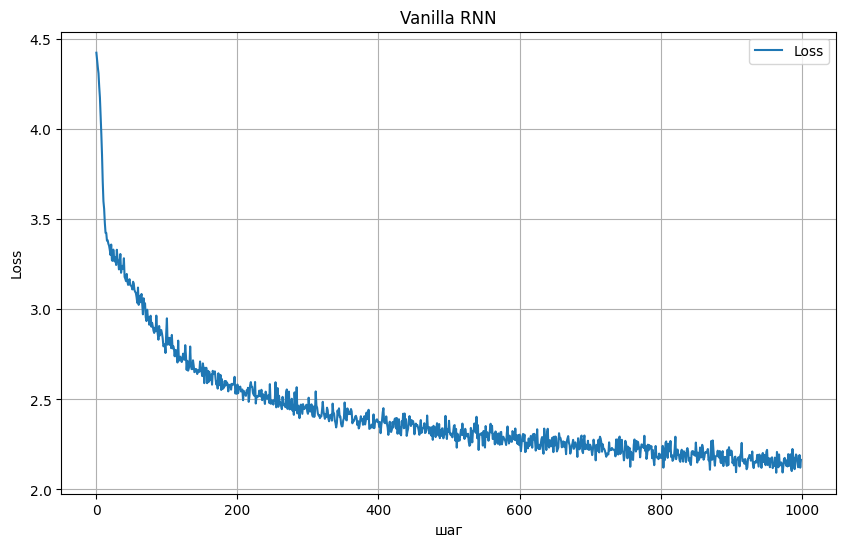

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(history, label='Loss')

plt.xlabel('шаг')
plt.ylabel('Loss')
plt.title('Vanilla RNN')

plt.legend()
plt.grid(True)

plt.show()

In [ ]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)

        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)

        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.num_tokens = num_tokens
        self.rnn_num_units = rnn_num_units

    def forward(self, x, state_prev=None):
        x_emb = self.emb(x)

        output, state_next = self.lstm(x_emb, state_prev)

        logits = self.hid_to_logits(output)

        return logits, state_next

    def initial_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.rnn_num_units),
                torch.zeros(1, batch_size, self.rnn_num_units))

model_lstm = CharLSTMLoop(num_tokens=num_tokens, emb_size=32, rnn_num_units=128)
opt = torch.optim.Adam(model_lstm.parameters())
criterion = nn.CrossEntropyLoss()

history_lstm = []

for i in range(1000):
    batch_x, batch_y = get_batch(text)

    logits, _ = model_lstm(batch_x)
    loss = criterion(logits.reshape(-1, num_tokens), batch_y.reshape(-1))

    opt.zero_grad()
    loss.backward()
    opt.step()

    history_lstm.append(loss.item())

    if (i+1) % 100 == 0:
        print(f"Шаг {i+1}, Loss {loss.item()}")

Шаг 100, Loss 3.0439939498901367
Шаг 200, Loss 2.645986795425415
Шаг 300, Loss 2.5328752994537354
Шаг 400, Loss 2.445042133331299
Шаг 500, Loss 2.380312442779541
Шаг 600, Loss 2.402773380279541
Шаг 700, Loss 2.2921853065490723
Шаг 800, Loss 2.251004934310913
Шаг 900, Loss 2.2431039810180664
Шаг 1000, Loss 2.2184317111968994


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=200, temperature=1.0):

    char_rnn.eval()
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    hid_state = char_rnn.initial_state(batch_size=1)

    if len(seed_phrase) > 1:
        _, hid_state = char_rnn(x_sequence[:, :-1], hid_state)

    current_char = x_sequence[:, -1].unsqueeze(1)

    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(current_char, hid_state)

        logits = out[0, 0]
        p_next = F.softmax(logits / temperature, dim=-1).detach().numpy()

        next_ix = np.random.choice(len(tokens), p=p_next)

        next_ix_tensor = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix_tensor], dim=1)
        current_char = next_ix_tensor

    return ''.join([tokens[ix] for ix in x_sequence[0].numpy()])

temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]

for temp in temperatures:
    print(f"температура: {temp}")
    print(generate_sample(model_lstm, seed_phrase='отчего я грустный', temperature=temp))
    print("\n")

температура: 0.1
отчего я грустный в поленье
не в серденный в сердце в нем не веренье,
и в не в серденье своет
и в серденный своет своет,
и сторова страстий в серденье
на востранный страстить в не в поленный,
и в серд


температура: 0.2
отчего я грустный,
поленье страстали своет,
и простали в постали советь
и в сердце в не моловой
и сердал он безденье в серденья,
в не в не сворой сверенье
не в не все продальной
и в сердали сторовы,
п


температура: 0.5
отчего я грустный,
не предли замина онуги стростой
и то призал камий страты
меже бал ненной и вы пролет
в я бруг не гудали полет
и поченье прилиза,
ото не дел аницы
заматил коражих бел поданим
и полет


температура: 1.0
отчего я грустный
онды умом мхых, нее дим урае
мен егодной знакнах,
тина и – пиютнуть,
и слана всучу…
лобеневь мнет не пиходиват нихов,
притреть примутет листавов татлою всудяя;
кадоня и и чак мо!
моп


температура: 2.0
отчего я грустный!»:.ю»,
 вгядно знавзнет….:мii:
як л»u,й!».). –. rе
зnlii9uд…xчk^а лоньть:»eы
а шbёъeв

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)